# Introduction to PyPSA

**Python for Power System Analysis (PyPSA)**

PyPSA is a python package that supports energy and electricity system modeling. The PyPSA package provides a framework for simulating and optimizing energy and electricity systems. PyPSA provides users structured components for which they can store the data which populates an optimization model.

## Learning Objectives

By the end of this session, you will:
1. Understand what PyPSA is and its core capabilities
2. Learn the basic components of a power system model in PyPSA
3. Build your first simple power system network
4. Run an economic dispatch model
5. Run a basic capacity expansion model
5. Visualize network topology and results

In [56]:
# Import necessary libraries
import pypsa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import logging

logger = logging.getLogger("gurobipy")
logger.propagate = False

pypsa.__version__

'0.35.2'

## 1. Anatomy of a PyPSA Network

Lets start with an example network. This is a pypsa-usa network created for ERCOT with:
- demand data for the year 2030 from the NREL EFS
- 7 buses nodes
- 380 resource regions
- 72 transmission links

In [57]:
path = os.path.join("../data/examples", "elec_s380_c7a_ec_lv1.5_RPS-REM-TCT-1h_E.nc")
network = pypsa.Network(path)
network

INFO:pypsa.network.io:Imported network '' has buses, carriers, generators, global_constraints, links, loads, storage_units


PyPSA Network ''
----------------
Components:
 - Bus: 7
 - Carrier: 17
 - Generator: 1355
 - GlobalConstraint: 1
 - Link: 22
 - Load: 7
 - StorageUnit: 14
Snapshots: 8760

In [58]:
network.buses

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,...,country,reeds_zone,reeds_ba,interconnect,nerc_reg,trans_reg,trans_grp,reeds_state,rec_trading_zone,substation_lv
Bus,,,,,,,,,,,,,,,,,,,,,
p60,230.0,,-100.465149,33.045614,AC,,,1.0,0.0,inf,...,p60,p60,ERCO,texas,ERCOT,ERCOT,ERCOT,TX,ERCOT,True
p61,230.0,,-101.298453,30.883641,AC,,,1.0,0.0,inf,...,p61,p61,ERCO,texas,ERCOT,ERCOT,ERCOT,TX,ERCOT,True
p62,230.0,,-102.583086,31.840422,AC,,,1.0,0.0,inf,...,p62,p62,ERCO,texas,ERCOT,ERCOT,ERCOT,TX,ERCOT,True
p63,230.0,,-96.863645,32.436442,AC,,,1.0,0.0,inf,...,p63,p63,ERCO,texas,ERCOT,ERCOT,ERCOT,TX,ERCOT,True
p64,230.0,,-97.678235,30.141432,AC,,,1.0,0.0,inf,...,p64,p64,ERCO,texas,ERCOT,ERCOT,ERCOT,TX,ERCOT,True
p65,230.0,,-98.111416,28.023661,AC,,,1.0,0.0,inf,...,p65,p65,ERCO,texas,ERCOT,ERCOT,ERCOT,TX,ERCOT,True
p67,230.0,,-95.371812,29.737889,AC,,,1.0,0.0,inf,...,p67,p67,ERCO,texas,ERCOT,ERCOT,ERCOT,TX,ERCOT,True


In [59]:
network.consistency_check()

In [60]:
print(set(network.generators.carrier))
network.generators

{'CCGT-95CCS', 'nuclear', 'coal', 'CCGT', 'OCGT', 'onwind', 'biomass', 'hydrogen_ct', 'solar', 'hydro', 'oil'}


,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt,vom_cost,fuel_cost,heat_rate,carrier_base,land_region
Generator,,,,,,,,,,,,,,,,,,,,,
p600 0 CCGT existing,p60,Slack,,1869.9,0.0,True,0.0,1869.9,0.0,1.0,...,1.0,1.0,1.0,12.000000,0.0,2.04,2.9163,6.238,CCGT,p600 0
p600 0 OCGT existing,p60,,,1.2,0.0,True,0.0,1.2,0.0,1.0,...,1.0,1.0,1.0,3.000000,0.0,6.94,2.9163,9.717,OCGT,p600 0
p600 0 oil,p60,,,536.4,0.0,False,536.4,inf,0.0,1.0,...,1.0,1.0,1.0,6.000000,0.0,NaN,4.6147,NaN,oil,p600 0
p600 0 onwind existing,p60,,,3682.8,0.0,False,0.0,3682.8,0.0,1.0,...,NaN,1.0,1.0,16057.082123,0.0,NaN,NaN,NaN,onwind,p600 0
p600 0 solar existing,p60,,,1345.8,0.0,False,0.0,1345.8,0.0,1.0,...,NaN,1.0,1.0,9405.538610,0.0,NaN,NaN,NaN,solar,p600 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p62 hydrogen_ct_2030,p62,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,NaN,1.0,1.0,1.000000,0.0,NaN,NaN,NaN,,
p63 hydrogen_ct_2030,p63,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,NaN,1.0,1.0,1.000000,0.0,NaN,NaN,NaN,,
p64 hydrogen_ct_2030,p64,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,NaN,1.0,1.0,1.000000,0.0,NaN,NaN,NaN,,


In [61]:
network.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
p60||p61_fwd,p60,p61,,AC,0.987274,True,0,inf,4270.071,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p60||p62_fwd,p60,p62,,AC,0.993721,True,0,inf,3303.403,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p60||p63_fwd,p60,p63,,AC,0.971904,True,0,inf,10383.198,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p61||p62_fwd,p61,p62,,AC,0.992017,True,0,inf,1522.014,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p61||p63_fwd,p61,p63,,AC,0.960224,True,0,inf,3393.601,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p61||p64_fwd,p61,p64,,AC,0.967756,True,0,inf,3008.900,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p61||p65_fwd,p61,p65,,AC,0.970447,True,0,inf,186.352,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p63||p64_fwd,p63,p64,,AC,0.978866,True,0,inf,7909.854,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p64||p65_fwd,p64,p65,,AC,0.991812,True,0,inf,6488.427,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [62]:
network.lines

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom
Line,,,,,,,,,,,,,,,,,,,,,


In [63]:
network.storage_units

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
p60 battery,p60,,,1141.3,0.0,False,0.0,1141.3,-1.0,1.0,...,False,NaN,True,True,1.557785,0.921954,0.921954,0.0,0.0,0.0
p61 battery,p61,,,1184.1,0.0,False,0.0,1184.1,-1.0,1.0,...,False,NaN,True,True,1.548856,0.921954,0.921954,0.0,0.0,0.0
p62 battery,p62,,,770.5,0.0,False,0.0,770.5,-1.0,1.0,...,False,NaN,True,True,1.775600,0.921954,0.921954,0.0,0.0,0.0
p63 battery,p63,,,2745.6,0.0,False,0.0,2745.6,-1.0,1.0,...,False,NaN,True,True,1.507503,0.921954,0.921954,0.0,0.0,0.0
p64 battery,p64,,,995.7,0.0,False,0.0,995.7,-1.0,1.0,...,False,NaN,True,True,1.674199,0.921954,0.921954,0.0,0.0,0.0
p65 battery,p65,,,1435.5,0.0,False,0.0,1435.5,-1.0,1.0,...,False,NaN,True,True,1.421386,0.921954,0.921954,0.0,0.0,0.0
p67 battery,p67,,,2059.5,0.0,False,0.0,2059.5,-1.0,1.0,...,False,NaN,True,True,1.474144,0.921954,0.921954,0.0,0.0,0.0
p60 4hr_battery_storage_2030,p60,PQ,,0.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,False,True,4.000000,0.921954,0.921954,0.0,0.0,0.0
p61 4hr_battery_storage_2030,p61,PQ,,0.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,False,True,4.000000,0.921954,0.921954,0.0,0.0,0.0


In [64]:
network.stores

attribute,bus,type,carrier,e_nom,e_nom_mod,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,...,sign,marginal_cost,marginal_cost_quadratic,marginal_cost_storage,capital_cost,standing_loss,active,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,


In [65]:
network.loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
p60 AC,p60,AC,,0.0,0.0,-1.0,True
p61 AC,p61,AC,,0.0,0.0,-1.0,True
p62 AC,p62,AC,,0.0,0.0,-1.0,True
p63 AC,p63,AC,,0.0,0.0,-1.0,True
p64 AC,p64,AC,,0.0,0.0,-1.0,True
p65 AC,p65,AC,,0.0,0.0,-1.0,True
p67 AC,p67,AC,,0.0,0.0,-1.0,True


But where is the load data?
The load data lives in the time-series component of loads, called loads_t

In [66]:
network.loads_t.p_set

Load                          p60 AC    p61 AC    p62 AC      p63 AC  \
period timestep                                                        
2030   2030-01-01 00:00:00  418.5019  839.1114  706.9347  18837.6403   
       2030-01-01 01:00:00  417.6566  837.4159  705.5063  18799.5797   
       2030-01-01 02:00:00  411.2959  824.6624  694.7616  18513.2684   
       2030-01-01 03:00:00  400.9471  803.9132  677.2809  18047.4545   
       2030-01-01 04:00:00  383.3342  768.5987  647.5290  17254.6620   
...                              ...       ...       ...         ...   
       2030-12-31 19:00:00  384.3792  770.6940  649.2941  17301.6950   
       2030-12-31 20:00:00  375.0132  751.9145  633.4731  16880.1155   
       2030-12-31 21:00:00  371.0165  743.9014  626.7219  16700.2180   
       2030-12-31 22:00:00  376.3994  754.6941  635.8149  16942.5145   
       2030-12-31 23:00:00  400.1710  802.3567  675.9693  18012.5104   

Load                           p64 AC     p65 AC      p67 AC  
period timestep                                               
2030   2030-01-01 00:00:00  5901.9725  9345.2755  12512.2045  
       2030-01-01 01:00:00  5890.0487  9326.3950  12486.9249  
       2030-01-01 02:00:00  5800.3444  9184.3568  12296.7528  
       2030-01-01 03:00:00  5654.4014  8953.2687  11987.3538  
       2030-01-01 04:00:00  5406.0145  8559.9681  11460.7707  
...                               ...        ...         ...  
       2030-12-31 19:00:00  5420.7494  8583.2995  11492.0101  
       2030-12-31 20:00:00  5288.6646  8374.1562  11211.9908  
       2030-12-31 21:00:00  5232.3027  8284.9096  11092.5018  
       2030-12-31 22:00:00  5308.2157  8405.1133  11253.4389  
       2030-12-31 23:00:00  5643.4531  8935.9315  11964.1424  

[8760 rows x 7 columns]

Similarly, we have time-series data from generators in the generators_t dictionary. Within the generators_t dictionary there are multiple dataframes with different types of data!

In [67]:
print("Time-series data keys:", network.generators_t.keys())

Time-series data keys: dict_keys(['p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'marginal_cost', 'marginal_cost_quadratic', 'efficiency', 'stand_by_cost', 'ramp_limit_up', 'ramp_limit_down', 'p', 'q', 'status', 'start_up', 'shut_down', 'mu_upper', 'mu_lower', 'mu_p_set', 'mu_ramp_limit_up', 'mu_ramp_limit_down'])


In [68]:
network.snapshots

MultiIndex([(2030, '2030-01-01 00:00:00'),
            (2030, '2030-01-01 01:00:00'),
            (2030, '2030-01-01 02:00:00'),
            (2030, '2030-01-01 03:00:00'),
            (2030, '2030-01-01 04:00:00'),
            (2030, '2030-01-01 05:00:00'),
            (2030, '2030-01-01 06:00:00'),
            (2030, '2030-01-01 07:00:00'),
            (2030, '2030-01-01 08:00:00'),
            (2030, '2030-01-01 09:00:00'),
            ...
            (2030, '2030-12-31 14:00:00'),
            (2030, '2030-12-31 15:00:00'),
            (2030, '2030-12-31 16:00:00'),
            (2030, '2030-12-31 17:00:00'),
            (2030, '2030-12-31 18:00:00'),
            (2030, '2030-12-31 19:00:00'),
            (2030, '2030-12-31 20:00:00'),
            (2030, '2030-12-31 21:00:00'),
            (2030, '2030-12-31 22:00:00'),
            (2030, '2030-12-31 23:00:00')],
           name='snapshot', length=8760)

In [69]:
network.snapshot_weightings

objective  stores  generators
period timestep                                          
2030   2030-01-01 00:00:00        1.0     1.0         1.0
       2030-01-01 01:00:00        1.0     1.0         1.0
       2030-01-01 02:00:00        1.0     1.0         1.0
       2030-01-01 03:00:00        1.0     1.0         1.0
       2030-01-01 04:00:00        1.0     1.0         1.0
...                               ...     ...         ...
       2030-12-31 19:00:00        1.0     1.0         1.0
       2030-12-31 20:00:00        1.0     1.0         1.0
       2030-12-31 21:00:00        1.0     1.0         1.0
       2030-12-31 22:00:00        1.0     1.0         1.0
       2030-12-31 23:00:00        1.0     1.0         1.0

[8760 rows x 3 columns]

In [70]:
network.investment_periods

Index([2030], dtype='int32', name='period')

In [71]:
network.investment_period_weightings

,objective,years
period,,
2030,1.0,1.0


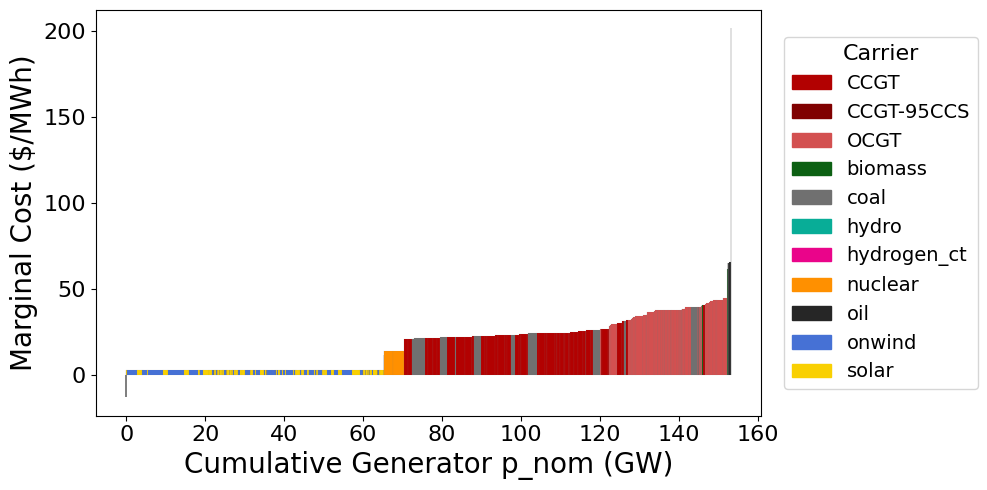

In [72]:
# Get generator data
gen_df = network.generators.copy()

# Sort by marginal_cost
gen_df_sorted = gen_df.sort_values("marginal_cost")

# For a bar plot where the width is p_nom, we need to use plt.bar with x and width arguments
# We'll use the cumulative sum of p_nom to set the left edge of each bar
p_nom = gen_df_sorted["p_nom"].values / 1000
marginal_cost = gen_df_sorted["marginal_cost"].replace(0, 3).values

# Calculate left positions for each bar
lefts = np.concatenate([[0], np.cumsum(p_nom)[:-1]])

# Get carrier colors for each generator
carrier_names = gen_df_sorted["carrier"].values
carrier_colors = network.carriers["color"].reindex(carrier_names).values

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(
    x=lefts,
    height=marginal_cost,
    width=p_nom,
    align='edge',
    edgecolor='grey',  # Remove border lines
    linewidth=0.05,
    color=carrier_colors
)

ax.set_xlabel("Cumulative Generator p_nom (GW)", fontsize=20)
ax.set_ylabel("Marginal Cost ($/MWh)", fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Add a legend mapping carrier colors to carrier names, positioned to the right of the plot
unique_carriers, idx = np.unique(carrier_names, return_index=True)
unique_colors = carrier_colors[idx]
handles = [mpatches.Patch(color=color, label=carrier) for carrier, color in zip(unique_carriers, unique_colors)]

ax.legend(handles=handles, title="Carrier", fontsize=14, title_fontsize=16, loc="center left", bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()

## Lets run the economic dispatch simulation

PyPSA's optimization function `pypsa.network.optimize()` builds the optimization model, either a simulation or production cost model depending on the extendable settings of each component.

We need to ensure all components are set to non-extendable before solving the network.

In [73]:
# You can use this to create an interactive list of components
network.components.keys()

dict_keys(['sub_networks', 'buses', 'carriers', 'global_constraints', 'lines', 'line_types', 'transformers', 'transformer_types', 'links', 'loads', 'generators', 'storage_units', 'stores', 'shunt_impedances', 'shapes'])

In [74]:
# Track and set all extendable attributes to False for all components in the network
extendable_attrs_backup = {}

for component in network.components.keys():
    extendable_attrs_backup[component] = {}
    for attr in ["p_nom_extendable", "s_nom_extendable", "e_nom_extendable"]:
        if attr in network.df(component).columns:
            # Backup the current state of the attribute
            extendable_attrs_backup[component][attr] = network.df(component)[attr].copy()
            # Set the attribute to False
            network.df(component)[attr] = False

Remember our load is for 2030, so lets reduce the system load for the sake of this simulation feasibility

In [75]:
network.loads_t.p_set *= 0.75

In [76]:
network.snapshots[0:1]

MultiIndex([(2030, '2030-01-01 00:00:00')],
           names=['period', 'timestep'])

In [77]:
network.optimize.create_model(
    snapshots=network.snapshots[0:1],
    multi_investment_periods=True,
)

Linopy LP model

Variables:
----------
 * Generator-p (snapshot, period, timestep, Generator)
 * Link-p (snapshot, period, timestep, Link)
 * StorageUnit-p_dispatch (snapshot, period, timestep, StorageUnit)
 * StorageUnit-p_store (snapshot, period, timestep, StorageUnit)
 * StorageUnit-state_of_charge (snapshot, period, timestep, StorageUnit)

Constraints:
------------
 * Generator-fix-p-lower (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-upper (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-ramp_limit_up (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-ramp_limit_down (snapshot, period, timestep, Generator-fix)
 * Link-fix-p-lower (snapshot, period, timestep, Link-fix)
 * Link-fix-p-upper (snapshot, period, timestep, Link-fix)
 * StorageUnit-fix-p_dispatch-lower (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_dispatch-upper (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_store-lower (snapshot, period, 

In [78]:
network.optimize.solve_model()


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.1s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1401 primals, 2823 duals
Objective: 3.80e+05
Solver model: available
Solver message: Optimal



Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-njl9oyh_ has 2823 rows; 1401 cols; 4246 nonzeros
Coefficient ranges:
  Matrix [9e-01, 1e+00]
  Cost   [1e+01, 2e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e-01, 1e+04]
Presolving model
7 rows, 345 cols, 367 nonzeros  0s
7 rows, 143 cols, 165 nonzeros  0s
Dependent equations search running on 7 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
7 rows, 143 cols, 165 nonzeros  0s
Presolve : Reductions: rows 7(-2816); columns 143(-1258); elements 165(-4081)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6116836589e-02 Pr: 7(37430.6) 0s
         13     3.8048508529e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-njl9oyh_
Model status        : Optimal
Simplex  

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [79]:
network.optimize.assign_solution()

In [80]:
# The above sequence of commands is equivalent to:
network.optimize(
    snapshots=network.snapshots[0:1],
    solver_name='gurobi'
)

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io: Writing time: 0.09s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-s__9yuo2.lp
Reading time = 0.01 seconds
obj: 2859 rows, 1419 columns, 4300 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2859 rows, 1419 columns and 4300 nonzeros
Model fingerprint: 0x997a362b
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+04]
Presolve removed 2852 rows and 1282 columns
Presolve time: 0.01s
Presolved: 7 rows, 137 columns, 159 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6521597e+04   4.460024e+03   0.000000e+00      0s
      14    3

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1419 primals, 2859 duals
Objective: 3.80e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

<Axes: xlabel='carrier'>

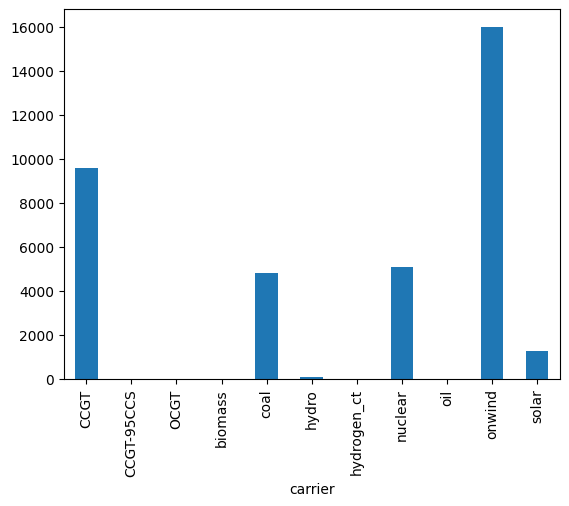

In [81]:
# lets look at the results
network.generators_t.p.loc[network.snapshots[0]].groupby(network.generators.carrier).sum().plot(kind="bar")
# only the first time step is solved!

Now lets solve a week!

In [82]:
network.optimize(
    snapshots=network.snapshots[0:7*24],
)

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 10.72it/s]
INFO:linopy.io: Writing time: 3.67s


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-f5pb11hg has 626270 rows; 238392 cols; 1017837 nonzeros
Coefficient ranges:
  Matrix [9e-01, 1e+00]
  Cost   [1e+01, 2e+02]
  Bound  [0e+00, 0e+00]
  RHS    [5e-02, 2e+04]
Presolving model
3020 rows, 62093 cols, 70653 nonzeros  0s
2686 rows, 29805 cols, 37697 nonzeros  0s
Dependent equations search running on 2352 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
2686 rows, 29805 cols, 37697 nonzeros  0s
Presolve : Reductions: rows 2686(-623584); columns 29805(-208587); elements 37697(-980140)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 1176(5.06216e+06) 0s
       5021     4.2245412861e+07 Pr: 0(0); Du: 0(2.66454e-14) 1s
       5021     4.2245412861e+07 Pr: 0(0); Du: 0(2.66454e-14) 1s
Solving

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 238392 primals, 626270 duals
Objective: 4.22e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

<Axes: xlabel='period,timestep'>

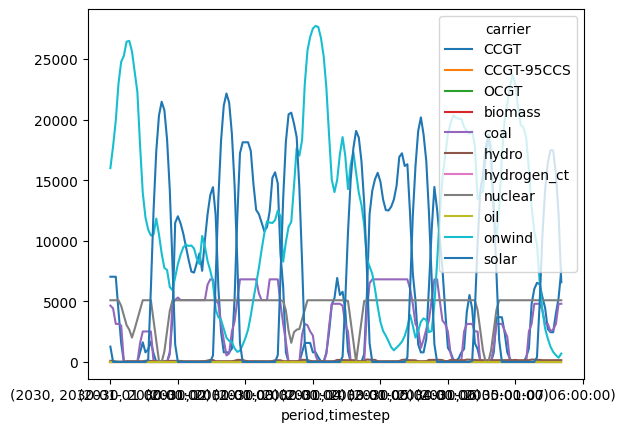

In [83]:
network.generators_t.p.loc[network.snapshots[0:7*24]].T.groupby(network.generators.carrier).sum().T.plot(kind="line")

But this only includes generators! we have storage units in out model and potentially stores, links, etc in other models!

In [84]:
network.carriers.loc['AC_exp', 'color'] = "#000000"

/Users/kamrantehranchi/Local_Documents/energy310_notebooks/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



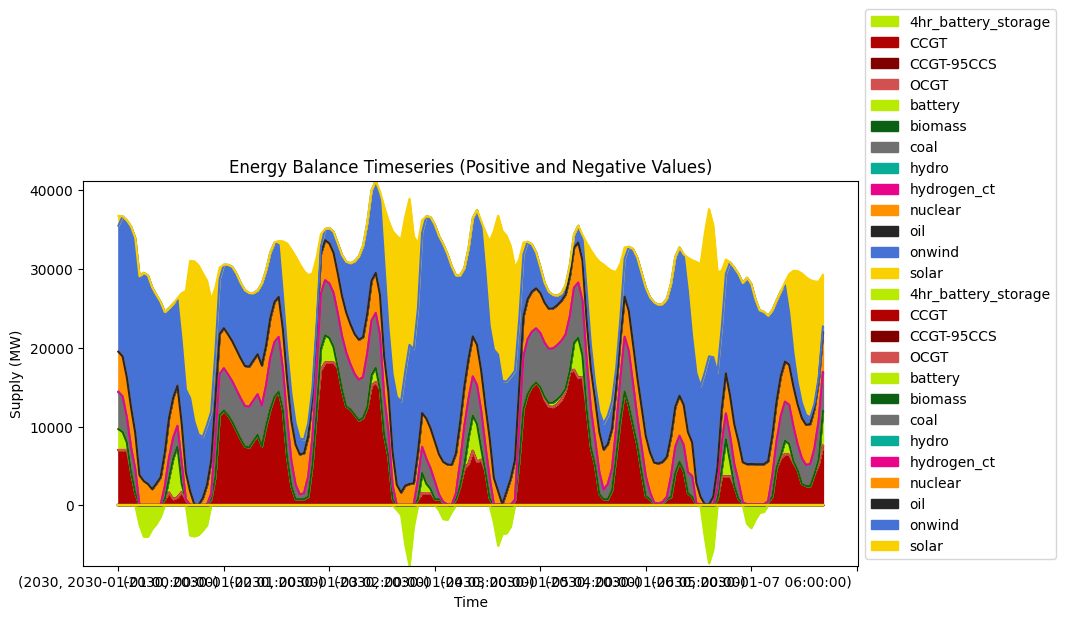

In [85]:
# Prepare the data
energy_balance = (
    network.statistics.energy_balance(comps=["Generator","StorageUnit"], aggregate_time=False, nice_names=False)
    .loc[:, :]
    .droplevel(0)
    .iloc[:, :7*24]
    .groupby("carrier")
    .sum()
    .where(lambda x: np.abs(x) > 0)
    .fillna(0)
    .T
)

# Separate positive and negative values
energy_pos = energy_balance.clip(lower=0)
energy_neg = energy_balance.clip(upper=0)

# Get color mapping for carriers
carrier_colors = network.carriers.color.reindex(energy_balance.columns)
color_dict = carrier_colors.to_dict()

# Plot both positive and negative values on the same plot, using carrier colors
fig, ax = plt.subplots(figsize=(10, 5))
energy_pos.plot.area(
    ax=ax, 
    stacked=True,
    legend=False,
    color=[color_dict.get(c, None) for c in energy_pos.columns]
)
energy_neg.plot.area(
    ax=ax, 
    stacked=True,
    legend=False,
    color=[color_dict.get(c, None) for c in energy_neg.columns]
)

# Fix y-limits to show the full range of data
ymin = energy_neg.sum(axis=1).min()
ymax = energy_pos.sum(axis=1).max()
ax.set_ylim(ymin, ymax)

ax.set_title("Energy Balance Timeseries (Positive and Negative Values)")
ax.set_ylabel("Supply (MW)")
ax.set_xlabel("Time")
# Combine legends from both plots
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1, 0), loc="lower left", title=None, ncol=1)
plt.show()

In [86]:
network.statistics()

Optimal Capacity Installed Capacity  \
                                                    2030               2030   
Generator   Biomass                              137.000            137.000   
            Ccgt-95Ccs                               NaN                NaN   
            Coal                               14329.700          14329.700   
            Combined-Cycle Gas                 41404.100          41404.100   
            Hydrogen Combustion Turbine              NaN                NaN   
            Nuclear                             5138.600           5138.600   
            Oil                                  799.800            799.800   
            Onshore Wind                       34363.600          34363.600   
            Open-Cycle Gas                     17071.700          17071.700   
            Reservoir & Dam                      555.100            555.100   
            Solar                              30326.000          30326.000   
Link        Ac                                 99247.628          99247.628   
Load        Ac                                     0.000              0.000   
StorageUnit 4Hr_Battery_Storage                      NaN                NaN   
            Battery Storage                    10332.200          10332.200   

                                               Supply    Withdrawal  \
                                                 2030          2030   
Generator   Biomass                               NaN           NaN   
            Ccgt-95Ccs                            NaN           NaN   
            Coal                         5.425517e+05           NaN   
            Combined-Cycle Gas           9.279408e+05           NaN   
            Hydrogen Combustion Turbine           NaN           NaN   
            Nuclear                      7.611423e+05           NaN   
            Oil                                   NaN           NaN   
            Onshore Wind                 1.973695e+06           NaN   
            Open-Cycle Gas                        NaN           NaN   
            Reservoir & Dam              1.763561e+04           NaN   
            Solar                        9.209533e+05           NaN   
Link        Ac                                    NaN  2.933294e+06   
Load        Ac                                    NaN  5.062156e+06   
StorageUnit 4Hr_Battery_Storage                   NaN           NaN   
            Battery Storage              8.483948e+04  9.981116e+04   

                                        Energy Balance  Transmission  \
                                                  2030          2030   
Generator   Biomass                                NaN  0.000000e+00   
            Ccgt-95Ccs                             NaN  0.000000e+00   
            Coal                          5.425517e+05  0.000000e+00   
            Combined-Cycle Gas            9.279408e+05  0.000000e+00   
            Hydrogen Combustion Turbine            NaN  0.000000e+00   
            Nuclear                       7.611423e+05  0.000000e+00   
            Oil                                    NaN  0.000000e+00   
            Onshore Wind                  1.973695e+06  0.000000e+00   
            Open-Cycle Gas                         NaN  0.000000e+00   
            Reservoir & Dam               1.763561e+04  0.000000e+00   
            Solar                         9.209533e+05  0.000000e+00   
Link        Ac                           -2.933294e+06  2.933294e+06   
Load        Ac                           -5.062156e+06  0.000000e+00   
StorageUnit 4Hr_Battery_Storage                    NaN  0.000000e+00   
            Battery Storage              -1.497167e+04  0.000000e+00   

                                        Capacity Factor   Curtailment  \
                                                   2030          2030   
Generator   Biomass                                 NaN  1.077287e+06   
            Ccgt-95Ccs                      

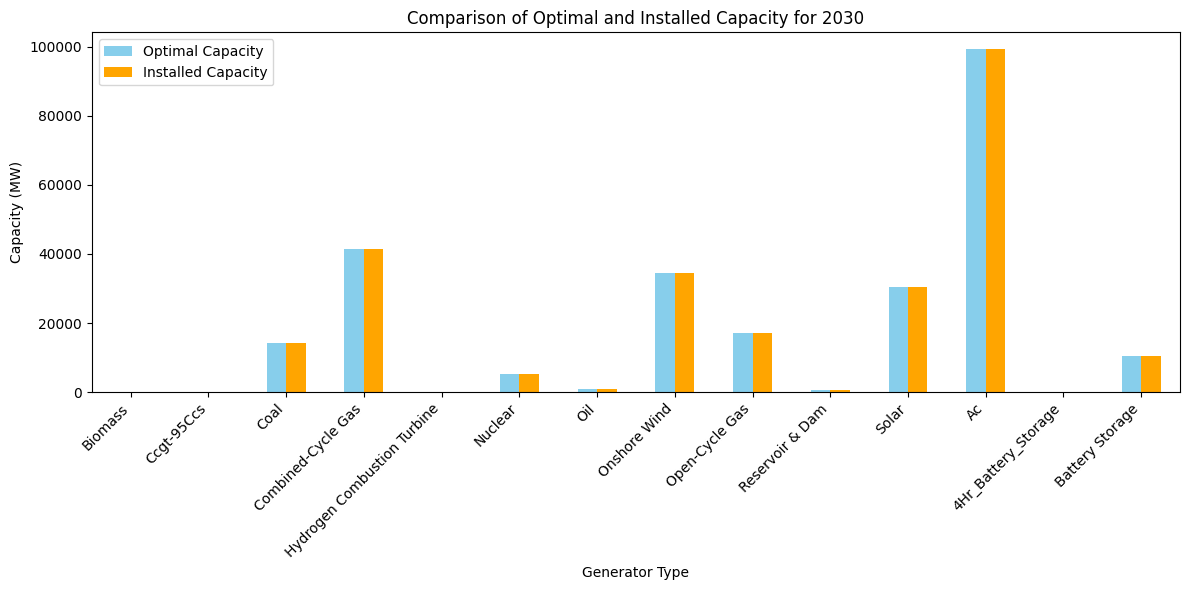

In [87]:
def plot_capacity_comparison(network):
    """
    Plots a comparison of Optimal and Installed Capacity for the year 2030 for a given network.

    Parameters:
    network: The network object containing the capacity data.
    """
    # Extract the 'Optimal Capacity' and 'Installed Capacity' for the year 2030
    optimal_capacity = network.statistics.optimal_capacity().droplevel(0)
    installed_capacity = network.statistics.installed_capacity().droplevel(0)

    # Create a DataFrame for plotting
    capacity_comparison = pd.DataFrame({
        'Optimal Capacity': optimal_capacity.squeeze(),
        'Installed Capacity': installed_capacity.squeeze()
    }, index=optimal_capacity.index)

    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    capacity_comparison.plot.bar(ax=ax, color=['skyblue', 'orange'])

    # Set plot labels and title
    ax.set_ylabel('Capacity (MW)')
    ax.set_title('Comparison of Optimal and Installed Capacity for 2030')
    ax.set_xlabel('Generator Type')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_capacity_comparison(network)

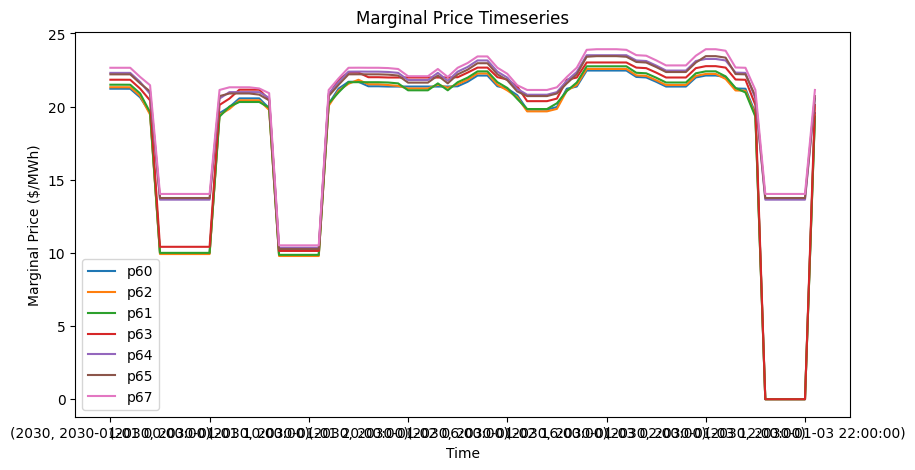

In [88]:
fig, ax = plt.subplots(figsize=(10, 5))
network.buses_t.marginal_price.iloc[:72].plot(ax=ax)
ax.set_title("Marginal Price Timeseries")
ax.set_ylabel("Marginal Price ($/MWh)")
ax.set_xlabel("Time")
plt.show()


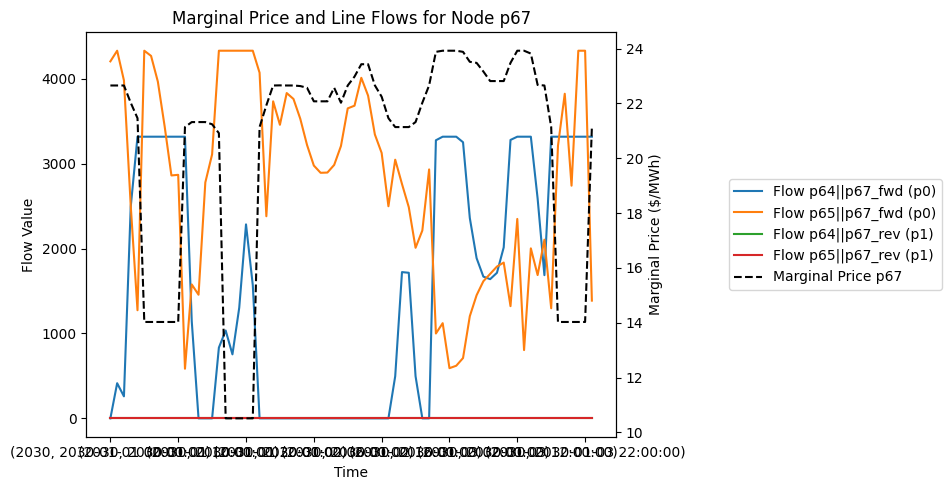

In [121]:
fig, ax1 = plt.subplots(figsize=(10, 5))

node = 'p67'
# Create a second y-axis for the marginal price
ax2 = ax1.twinx()

# Plot marginal price for node p64 as a dotted line on the second y-axis
network.buses_t.marginal_price[node].iloc[:72].plot(ax=ax2, linestyle='--', color='black', label='Marginal Price '+node)

# Find links connected to node p64
links_p64 = network.links[(network.links['bus0'] == node) | (network.links['bus1'] == node)]

# Plot line flows for links connected to node p64
for link in links_p64.index:
    if 'fwd' in link:
        network.links_t.p0[link].iloc[:72].plot(ax=ax1, label=f'Flow {link} (p0)')
    elif 'rev' in link:
        network.links_t.p1[link].iloc[:72].plot(ax=ax1, label=f'Flow {link} (p1)')
    # break

ax1.set_title("Marginal Price and Line Flows for Node "+node)
ax1.set_ylabel("Flow Value")
ax1.set_xlabel("Time")
ax2.set_ylabel("Marginal Price ($/MWh)")

# Combine legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.show()

### But that wasn't a single node network!

In [ ]:
busmap = network.buses.interconnect
cols = ['Pd', 'country', 'reeds_zone']
[network.buses.drop(columns=col, inplace=True) for col in cols if col in network.buses.columns]
clustered_network = network.cluster.cluster_by_busmap(busmap)

       'p61||p63_fwd', 'p61||p64_fwd', 'p61||p65_fwd', 'p63||p64_fwd',
       'p64||p65_fwd', 'p64||p67_fwd', 'p65||p67_fwd', 'p60||p61_rev',
       'p60||p62_rev', 'p60||p63_rev', 'p61||p62_rev', 'p61||p63_rev',
       'p61||p64_rev', 'p61||p65_rev', 'p63||p64_rev', 'p64||p65_rev',
       'p64||p67_rev', 'p65||p67_rev'],
      dtype='object', name='Link') for attribute p0 of Link are not in main components dataframe links
       'p61||p63_fwd', 'p61||p64_fwd', 'p61||p65_fwd', 'p63||p64_fwd',
       'p64||p65_fwd', 'p64||p67_fwd', 'p65||p67_fwd', 'p60||p61_rev',
       'p60||p62_rev', 'p60||p63_rev', 'p61||p62_rev', 'p61||p63_rev',
       'p61||p64_rev', 'p61||p65_rev', 'p63||p64_rev', 'p64||p65_rev',
       'p64||p67_rev', 'p65||p67_rev'],
      dtype='object', name='Link') for attribute p1 of Link are not in main components dataframe links


In [128]:
clustered_network.optimize(snapshots=clustered_network.snapshots[0:72], solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 20.19it/s]
INFO:linopy.io: Writing time: 1.54s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-h8t5mhss.lp
Reading time = 0.38 seconds
obj: 264302 rows, 100584 columns, 428877 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 264302 rows, 100584 columns and 428877 nonzeros
Model fingerprint: 0x20bac07a
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 4e+04]
Presolve removed 263584 rows and 97547 columns
Presolve time: 0.09s
Presolved: 718 rows, 3179 columns, 4975 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 100584 primals, 264302 duals
Objective: 1.92e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

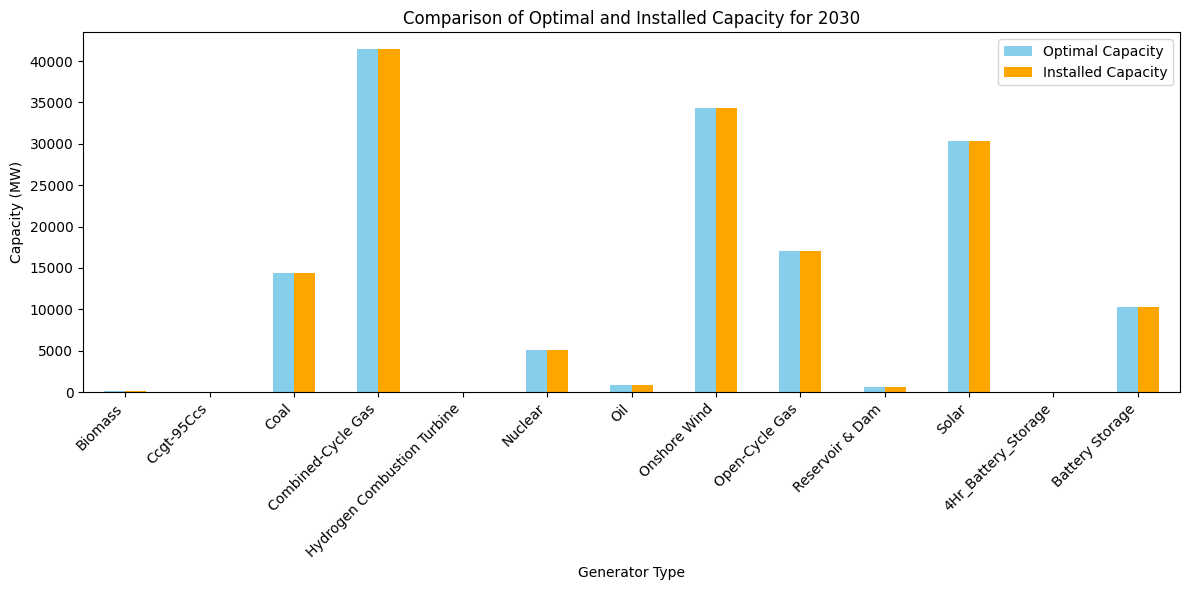

In [129]:
plot_capacity_comparison(clustered_network)

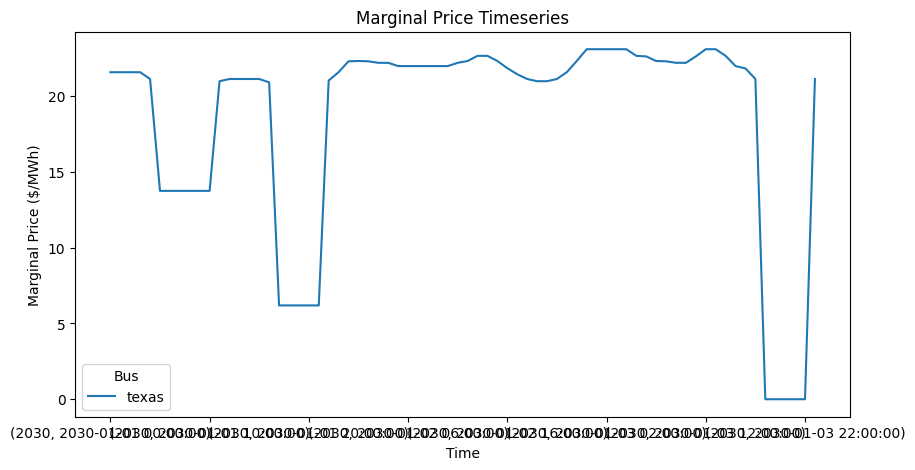

In [130]:
fig, ax = plt.subplots(figsize=(10, 5))
clustered_network.buses_t.marginal_price.iloc[:72].plot(ax=ax)
ax.set_title("Marginal Price Timeseries")
ax.set_ylabel("Marginal Price ($/MWh)")
ax.set_xlabel("Time")
plt.show()


## Now lets make this a capacity expansion problem

In [133]:
#restore the original extendable attributes
for component, attributes in extendable_attrs_backup.items():
    for attr, original_value in attributes.items():
        network.df(component)[attr] = original_value


<Axes: xlabel='period,timestep'>

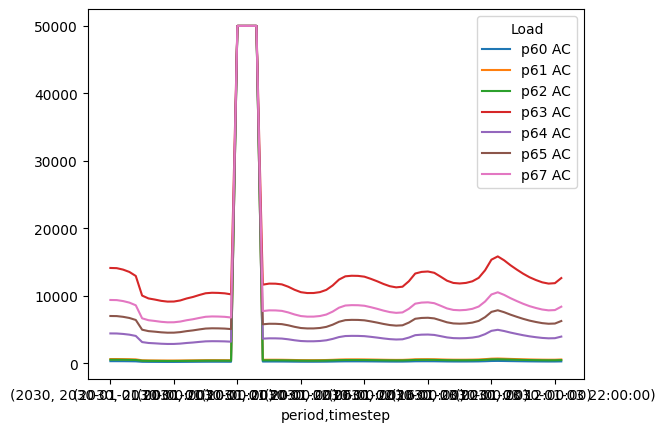

In [134]:
# network.loads_t.p_set /= 0.75
network.loads_t.p_set.iloc[20:24] = 50000 # set arbitrarily large load for 4 hour to show impacts of expansion
network.loads_t.p_set.iloc[:72].plot()


In [136]:
network.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
p60||p61_fwd,p60,p61,,AC,0.987274,True,0,inf,4270.071,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,4270.071
p60||p62_fwd,p60,p62,,AC,0.993721,True,0,inf,3303.403,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,3303.403
p60||p63_fwd,p60,p63,,AC,0.971904,True,0,inf,10383.198,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,10383.198
p61||p62_fwd,p61,p62,,AC,0.992017,True,0,inf,1522.014,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1522.014
p61||p63_fwd,p61,p63,,AC,0.960224,True,0,inf,3393.601,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,3393.601
p61||p64_fwd,p61,p64,,AC,0.967756,True,0,inf,3008.900,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,3008.900
p61||p65_fwd,p61,p65,,AC,0.970447,True,0,inf,186.352,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,186.352
p63||p64_fwd,p63,p64,,AC,0.978866,True,0,inf,7909.854,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,7909.854
p64||p65_fwd,p64,p65,,AC,0.991812,True,0,inf,6488.427,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,6488.427


In [137]:
network.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt,vom_cost,fuel_cost,heat_rate,carrier_base,land_region
Generator,,,,,,,,,,,,,,,,,,,,,
p600 0 CCGT existing,p60,Slack,,1869.9,0.0,True,0.0,1869.9,0.0,1.0,...,1.0,1.0,1.0,12.000000,1869.9,2.04,2.9163,6.238,CCGT,p600 0
p600 0 OCGT existing,p60,,,1.2,0.0,True,0.0,1.2,0.0,1.0,...,1.0,1.0,1.0,3.000000,1.2,6.94,2.9163,9.717,OCGT,p600 0
p600 0 oil,p60,,,536.4,0.0,False,536.4,inf,0.0,1.0,...,1.0,1.0,1.0,6.000000,536.4,NaN,4.6147,NaN,oil,p600 0
p600 0 onwind existing,p60,,,3682.8,0.0,False,0.0,3682.8,0.0,1.0,...,NaN,1.0,1.0,16057.082123,3682.8,NaN,NaN,NaN,onwind,p600 0
p600 0 solar existing,p60,,,1345.8,0.0,False,0.0,1345.8,0.0,1.0,...,NaN,1.0,1.0,9405.538610,1345.8,NaN,NaN,NaN,solar,p600 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p62 hydrogen_ct_2030,p62,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,NaN,1.0,1.0,1.000000,0.0,NaN,NaN,NaN,,
p63 hydrogen_ct_2030,p63,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,NaN,1.0,1.0,1.000000,0.0,NaN,NaN,NaN,,
p64 hydrogen_ct_2030,p64,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,NaN,1.0,1.0,1.000000,0.0,NaN,NaN,NaN,,


In [140]:
network.generators.groupby("carrier").p_nom_extendable.value_counts()

carrier      p_nom_extendable
CCGT         True                 94
CCGT-95CCS   True                  7
OCGT         True                276
biomass      False                 7
coal         True                 20
hydro        False                10
hydrogen_ct  True                  7
nuclear      True                 11
oil          False                29
onwind       True                373
             False                52
solar        True                371
             False                98
Name: count, dtype: int64

In [142]:
network.optimize(snapshots=network.snapshots[0:72], solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 43.67it/s]
INFO:linopy.io: Writing time: 2.14s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-ee3x7ges.lp
Reading time = 0.42 seconds
obj: 270032 rows, 103357 columns, 562700 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 270032 rows, 103357 columns and 562700 nonzeros
Model fingerprint: 0x433e7c0e
Coefficient statistics:
  Matrix range     [1e-03, 6e+02]
  Objective range  [1e+00, 5e+05]
  Bounds range     [5e+09, 5e+09]
  RHS range        [1e-03, 5e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 143190 rows and 30872 columns
Presolve time: 0.37s
Presolved: 126842 rows, 72485 columns, 383527 nonzeros

Concurre

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 103357 primals, 270032 duals
Objective: 2.28e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-ext-p-ramp_limit_up, Generator-ext-p-ramp_limit_down, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

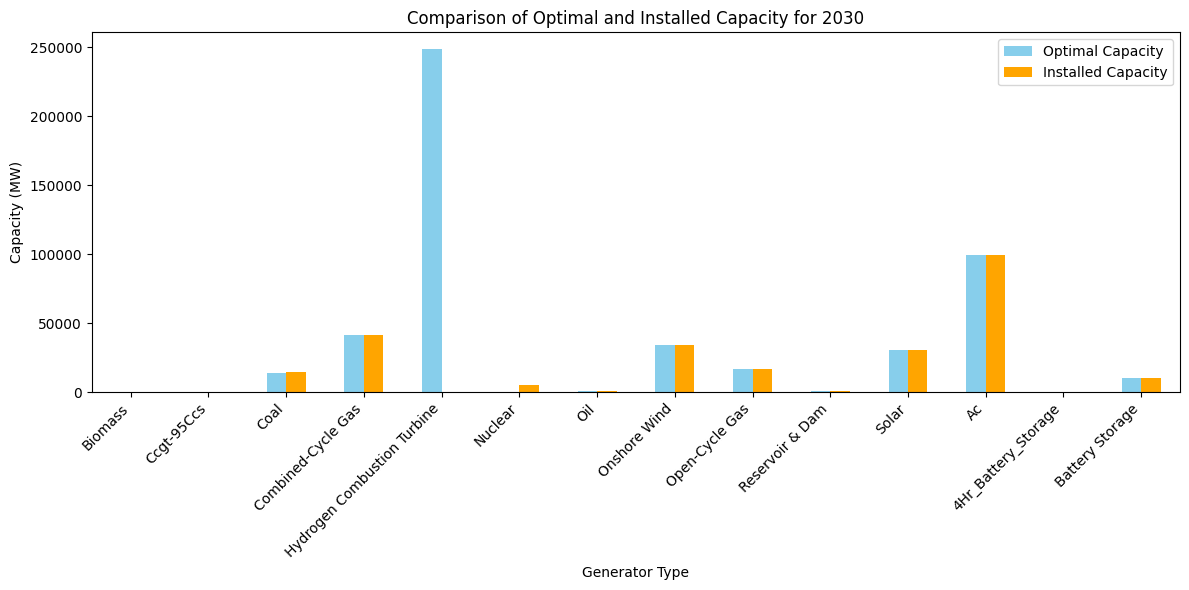

In [143]:
plot_capacity_comparison(network)

/Users/kamrantehranchi/Local_Documents/energy310_notebooks/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



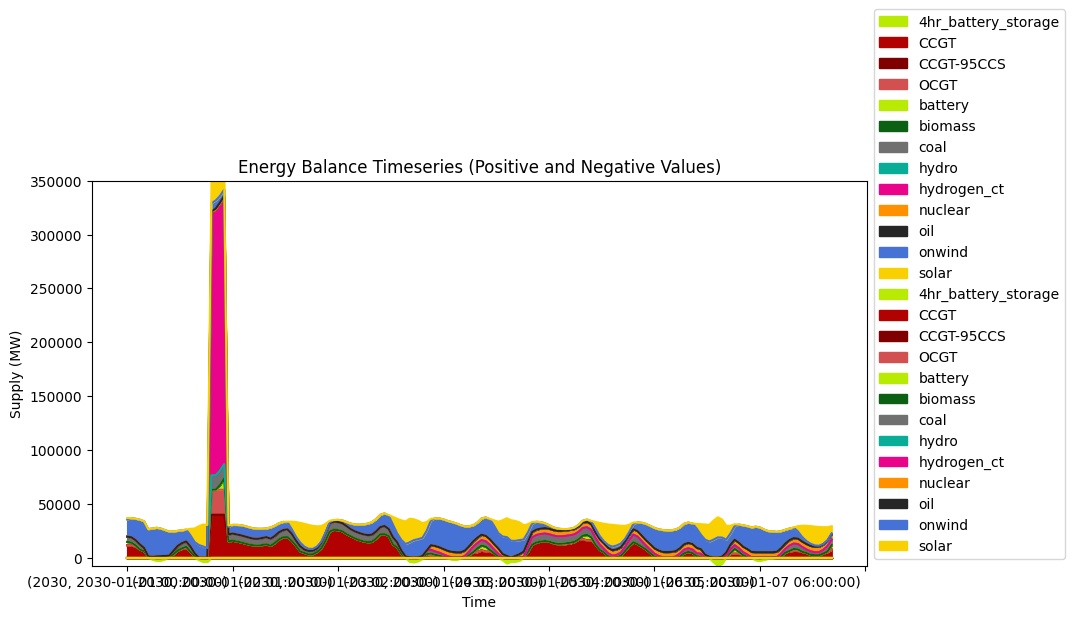

In [141]:
# Prepare the data
energy_balance = (
    network.statistics.energy_balance(comps=["Generator","StorageUnit"], aggregate_time=False, nice_names=False)
    .loc[:, :]
    .droplevel(0)
    .iloc[:, :7*24]
    .groupby("carrier")
    .sum()
    .where(lambda x: np.abs(x) > 0)
    .fillna(0)
    .T
)

# Separate positive and negative values
energy_pos = energy_balance.clip(lower=0)
energy_neg = energy_balance.clip(upper=0)

# Get color mapping for carriers
carrier_colors = network.carriers.color.reindex(energy_balance.columns)
color_dict = carrier_colors.to_dict()

# Plot both positive and negative values on the same plot, using carrier colors
fig, ax = plt.subplots(figsize=(10, 5))
energy_pos.plot.area(
    ax=ax, 
    stacked=True,
    legend=False,
    color=[color_dict.get(c, None) for c in energy_pos.columns]
)
energy_neg.plot.area(
    ax=ax, 
    stacked=True,
    legend=False,
    color=[color_dict.get(c, None) for c in energy_neg.columns]
)

# Fix y-limits to show the full range of data
ymin = energy_neg.sum(axis=1).min()
ymax = energy_pos.sum(axis=1).max()
ax.set_ylim(ymin, ymax)

ax.set_title("Energy Balance Timeseries (Positive and Negative Values)")
ax.set_ylabel("Supply (MW)")
ax.set_xlabel("Time")
# Combine legends from both plots
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1, 0), loc="lower left", title=None, ncol=1)
plt.show()

In [144]:
network.snapshot_weightings.iloc[0:72] = 8760/72

In [145]:
network.optimize(snapshots=network.snapshots[0:72], solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 41.31it/s]
INFO:linopy.io: Writing time: 1.87s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-l7f80pay.lp
Reading time = 0.57 seconds
obj: 270032 rows, 103357 columns, 562700 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 270032 rows, 103357 columns and 562700 nonzeros
Model fingerprint: 0xb88c1fee
Coefficient statistics:
  Matrix range     [1e-03, 6e+02]
  Objective range  [1e+00, 5e+05]
  Bounds range     [5e+09, 5e+09]
  RHS range        [1e-03, 5e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 143190 rows and 30872 columns
Presolve time: 0.36s
Presolved: 126842 rows, 72485 columns, 383527 nonzeros

Concurre

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 103357 primals, 270032 duals
Objective: 3.42e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-ext-p-ramp_limit_up, Generator-ext-p-ramp_limit_down, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

/Users/kamrantehranchi/Local_Documents/energy310_notebooks/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



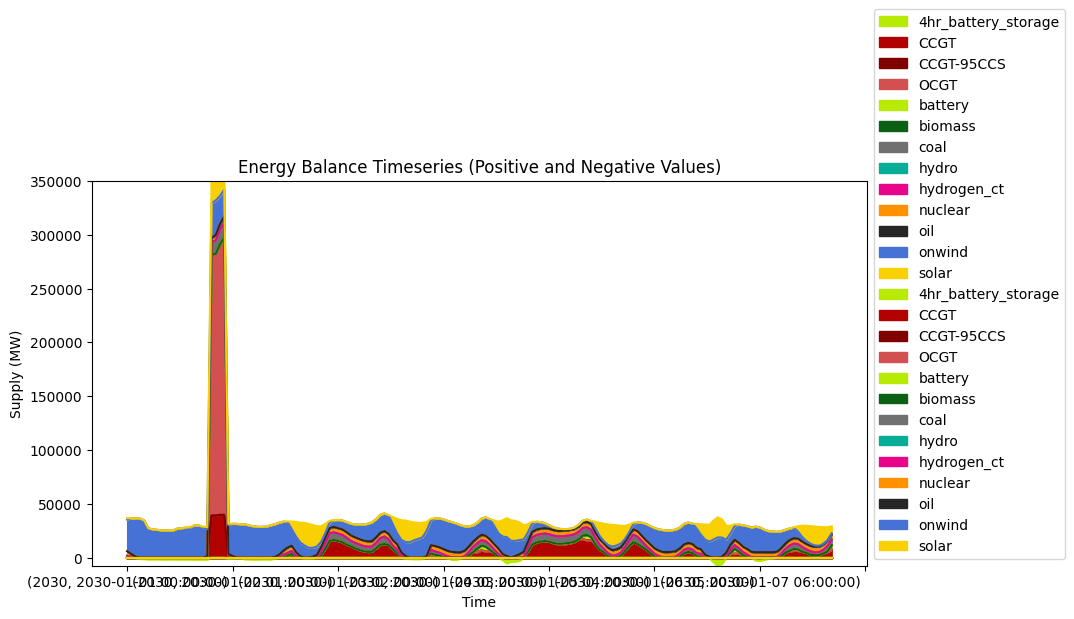

In [146]:
# Prepare the data
energy_balance = (
    network.statistics.energy_balance(comps=["Generator","StorageUnit"], aggregate_time=False, nice_names=False)
    .loc[:, :]
    .droplevel(0)
    .iloc[:, :7*24]
    .groupby("carrier")
    .sum()
    .where(lambda x: np.abs(x) > 0)
    .fillna(0)
    .T
)

# Separate positive and negative values
energy_pos = energy_balance.clip(lower=0)
energy_neg = energy_balance.clip(upper=0)

# Get color mapping for carriers
carrier_colors = network.carriers.color.reindex(energy_balance.columns)
color_dict = carrier_colors.to_dict()

# Plot both positive and negative values on the same plot, using carrier colors
fig, ax = plt.subplots(figsize=(10, 5))
energy_pos.plot.area(
    ax=ax, 
    stacked=True,
    legend=False,
    color=[color_dict.get(c, None) for c in energy_pos.columns]
)
energy_neg.plot.area(
    ax=ax, 
    stacked=True,
    legend=False,
    color=[color_dict.get(c, None) for c in energy_neg.columns]
)

# Fix y-limits to show the full range of data
ymin = energy_neg.sum(axis=1).min()
ymax = energy_pos.sum(axis=1).max()
ax.set_ylim(ymin, ymax)

ax.set_title("Energy Balance Timeseries (Positive and Negative Values)")
ax.set_ylabel("Supply (MW)")
ax.set_xlabel("Time")
# Combine legends from both plots
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1, 0), loc="lower left", title=None, ncol=1)
plt.show()

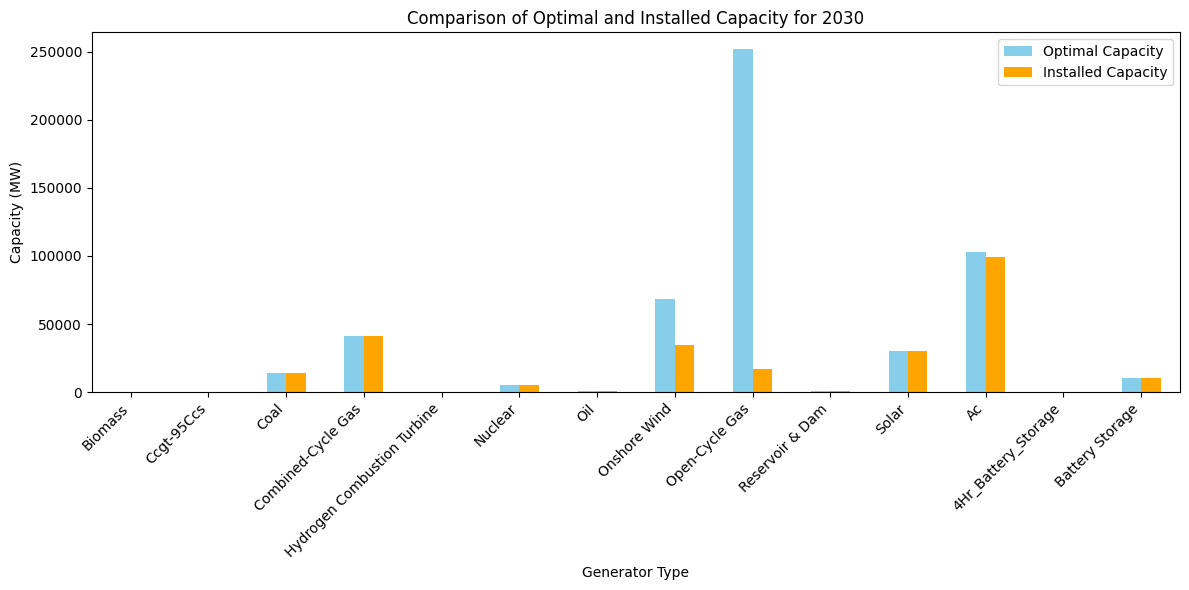

In [147]:
plot_capacity_comparison(network)